# 6.5 a 2D-example
see https://arxiv.org/abs/2305.00066

In [1]:
import numpy as np
from scipy.signal import convolve, convolve2d
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator as rgi
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from timeit import default_timer as tmr
from scipy.ndimage import gaussian_filter1d

In [2]:
from initial_conditions import Domain, Heaviside, LinearRamp, SmoothRamp, Sigmoid, CkRamp
from basis_functions import SVD, Trigonometric, Trigonometric2, TrigonometricOdd, Greedy, LNA, LPF, Sinc

In [3]:
import sys, numpy, scipy, matplotlib
print("Python version:", sys.version)
print("NumPy version:", numpy.__version__)
print("SciPy version:", scipy.__version__)
print("matplotlib version:", matplotlib.__version__)

Python version: 3.13.0 | packaged by conda-forge | (main, Oct  8 2024, 19:54:55) [MSC v.1941 64 bit (AMD64)]
NumPy version: 2.1.2
SciPy version: 1.14.1
matplotlib version: 3.9.2


## choose between 1 and 2, to run the 1D or 2D example

In [4]:
s = 5
m1, m2, n, r = 750, 750, 750,  500

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = plt.cm.plasma
page_width_pt = 455.24
pt2in = 0.01389 
pt2cm = 0.0352777778
cm2in = 1/2.54
plot_width_in = page_width_pt*pt2in/2
print(plot_width_in/cm2in)

fs = 10
fs_lbl = 6
plt.rcParams["figure.figsize"] = (plot_width_in, plot_width_in/1.61803398875)
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.size'] = fs
plt.rcParams['axes.titlesize'] = fs
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
plt.rcParams['legend.labelspacing'] = 0.0
plt.rcParams['legend.fontsize'] = fs_lbl
plt.rcParams['legend.handlelength'] = 1.0

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', size=12, serif='Computer Modern Roman')
pth = "../Plots/"

8.030570172000001


In [6]:
def plot_f_2D(y):
    fig, ax = plt.subplots()
    m, n = y.shape
    cs = ax.imshow(y[:, n//2:], extent=[0, 1, 0, 1], vmin=-1, vmax=1, zorder=1, origin="lower")
    ax.imshow(y, extent=[-1, 1, 0, 1], vmin=-1, vmax=1, zorder=1, origin="lower", alpha=.5)
    #plt.grid()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="7.5%", pad=0.35)
    plt.colorbar(cs, orientation='horizontal', cax=cax)
    ax.add_patch(Rectangle((0, 0), 1, 1, fill=False, ec="k", lw=5, alpha=1))
    ax.text(.5, 0.5, r'$\Omega$', fontdict={"fontsize": 32, "color": "k", "ha": 'center', "va": "center"})
    ax.text(-.5, 0.53, r'inflow', fontdict={"fontsize": 10})
    ax.annotate("", xy=(0.0, 0.5), xytext=(-.5, 0.5), color="white", arrowprops=dict(arrowstyle="->"))
    #plt.show()
    return fig, ax

## make a random initial condition

In [7]:
def make_random_IC_2D(nx=20, ny=10):
    xe = np.linspace(-1, 1, nx+1)
    xm = (xe[1:]+xe[:-1])/2
    ye = np.linspace(0, 1, ny+1)
    ym = (ye[1:]+ye[:-1])/2
    Xm, Ym = np.meshgrid(xm, ym, indexing="ij")
    steps = np.random.rand(nx, ny)*2-1
    print(Xm.shape, Ym.shape)
    print(steps.shape)
    print()

    interp  = rgi([xm, ym], steps, method="nearest", bounds_error=False, fill_value=None)
    xe = np.linspace(-1, 1, 2*m1+1)
    xi = (xe[1:]+xe[:-1])/2
    ye = np.linspace(0, 1, m2+1)
    yi = (ye[1:]+ye[:-1])/2

    #Xi, Yi = np.meshgrid(xi, yi, indexing="xy")
    #pts = np.c_[Xi.ravel(), Yi.ravel()]
    #y = interp(pts).reshape(m, 2*m)

    #Xi, Yi = np.meshgrid(xi, yi, indexing="ij")
    #pts = np.c_[Xi.ravel(), Yi.ravel()]
    #y = interp(pts).reshape(2*m, m).T

    Yi, Xi = np.meshgrid(yi, xi, indexing="ij")
    pts = np.c_[Xi.ravel(), Yi.ravel()]
    y = interp(pts).reshape(m1, 2*m2)

    fig_fk, ax_fk = plot_f_2D(y)
    #fig, ax = plt.subplots()
    #plt.scatter(Xm, Ym, c=steps, vmin=-1, vmax=1, zorder=2, edgecolors='black')
    fig_fk.savefig(pth+"randomIC_2D.pdf")
    plt.show()
    print(xm[0], ym[0])
    print(steps[0, 0])
    print(y[0, 0])
    return y

(10, 5) (10, 5)
(10, 5)



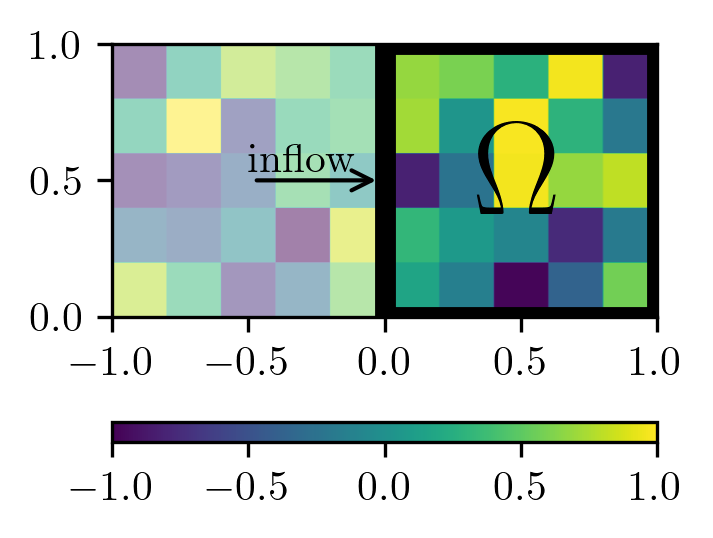

-0.9 0.1
0.7803717733762885
0.7803717733762885


In [8]:
f = make_random_IC_2D(nx=s*2, ny=s)

## k- fold convolution, SVD and error computation

In [9]:
p = 2
all_SVDs = {}
print(f.shape)
d_Ns = {}
delta_Ns = {}
f_convolved = {}

w = np.int32(m1/s)
h = np.int32(m2/s)
print(w, h)
print(f.shape)
kernel = np.ones((h, w), dtype=np.float64) / (w*h)

m_p, n_p = 5*h, 5*w
f_convolved[0] = np.zeros((m1+2*m_p, 2*m2+2*n_p))
f_convolved[0][m_p:-m_p, n_p:-n_p] = f.copy()


for k in range(5):
    print(k)
    t0 = tmr()
    fk = f_convolved[k][m_p:-m_p, n_p:-n_p].copy()
    Xk = np.zeros((m1*m2, n))
    for j in range(n):
        Xk[:, j] = fk[:, (m2-j):(m2-j+m2)].ravel()
    t1 = tmr()
    print("snapshot matrix made", t1-t0)

    svd_basis = SVD(Xk)
    all_SVDs[k] = svd_basis
    t2 = tmr()
    print("SVD'ed", t2-t1)

    delta_n, d_n = svd_basis.calc_error()
    d_Ns[k] = d_n
    delta_Ns[k] = delta_n
    t3 = tmr()
    print("error calculated", t3-t2)

    f_convolved[k+1] = convolve(f_convolved[k], kernel, 'same')
    _fk_ = f_convolved[k+1]
    t4 = tmr()
    print("convolved", t4-t3)

(750, 1500)
150 150
(750, 1500)
0
snapshot matrix made 5.275580098852515
SVD'ed 24.695195300504565
error calculated 0.0004916004836559296
convolved 0.3658855985850096
1
snapshot matrix made 4.308467300608754
SVD'ed 22.01482990011573
error calculated 0.0006207004189491272
convolved 0.38504029996693134
2
snapshot matrix made 3.829798499122262
SVD'ed 22.14923500083387
error calculated 0.00047919899225234985
convolved 0.29447670094668865
3
snapshot matrix made 3.258611399680376
SVD'ed 24.355928000062704
error calculated 0.0007269997149705887
convolved 0.299422699958086
4
snapshot matrix made 3.2596495002508163
SVD'ed 20.805175499990582
error calculated 0.0004556998610496521
convolved 0.303132900968194


## Fig. 7 (b) Kolmorogov N -width for $C^k(\Omega_P)$-conditions, k = 0, ..., 3.

1.4552676302708876
6.359894106349541
37.37026478983024
246.2781557595599
1777.7872445003359


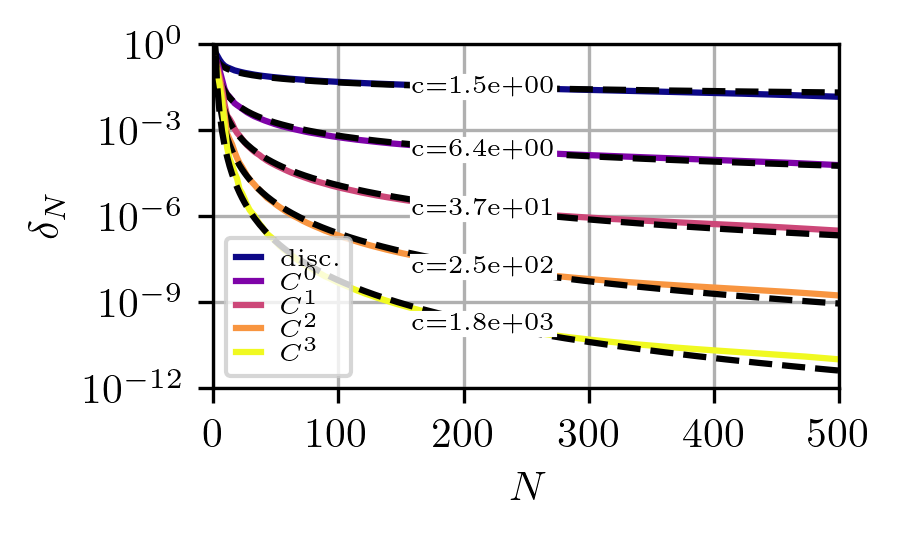

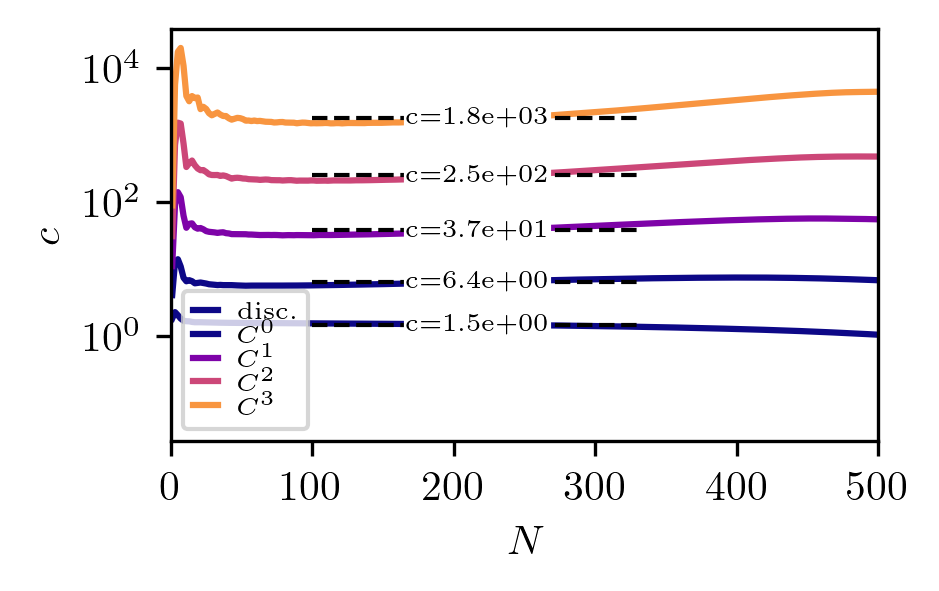

In [10]:
p = 2
    
fig_dN, ax_dN = plt.subplots(tight_layout=True)
fig_d_est, ax_d_est = plt.subplots(tight_layout=True)

for i in range(5):
    k = i-1
    if i == 0:
        lbl = "disc."
    else:
        lbl = "$C^{:.0f}$".format(k)
    d_n = d_Ns[i]
    delta_n = delta_Ns[i]

    N = np.arange(len(delta_n))+1
    ax_dN.plot(N[::p], delta_n[::p], "-", color=cmap(i/4), label=lbl)
    
    model = 1/np.pi**(k+2) * N**(-(2*k+3)/2)
    C = delta_n/model
    C_estimated = np.mean(C[100: r//3*2])
    print(C_estimated)
    #ax.plot(N, C_estimated*model, "k--", lw=1, ms=0)

    ax_d_est.plot(N[::p], C[::p], "-", color=cmap(k/4), label=lbl)
    ax_d_est.plot([100, r/3*2], [C_estimated, C_estimated], "k--", lw=1)
    ltex = ax_d_est.text(r/3+50, C_estimated, "c={:.1e}".format(C_estimated), size=6, color="k",
                         ha="center", va="center", bbox=dict(ec='1',fc='1', pad=0))
    ax_dN.plot(N[::p], model[::p]*C_estimated, "k--")
    ltex = ax_dN.text(r//3+50, model[r//3+50]*C_estimated, "c={:.1e}".format(C_estimated), size=6, color="k",
                         ha="center", va="center", bbox=dict(ec='1',fc='1', pad=0))

ax_dN.set_ylim([1e-12, 1e+0])
ax_dN.set_xlim([0, r]) 
ax_dN.set_yscale('log')
ax_dN.legend()
ax_dN.set_xlabel(r'$N$')
ax_dN.set_ylabel(r'$\delta_N$')
ax_dN.grid(which="both")


plt.tight_layout()

ax_d_est.legend()
ax_d_est.set_yscale('log')
ax_d_est.set_xlim([0, r])
#ax_d_est.set_ylim([0, 10])
ax_d_est.set_xlabel(r'$N$')
ax_d_est.set_ylabel(r'$c$')

fig_dN.savefig(pth+"random_2D_decay.pdf")

plt.show()

In [11]:
# N = np.arange(r)
# for i in range(4):
#     fig, ax = plt.subplots()
#     plt.plot(N, (delta_Ns[i]/delta_Ns[i+1])[N])
#     #plt.xlim(0, 750)
#     #plt.ylim(0, 25)
#     plt.ylabel("dN_{:.0f}/dN_{:.0f}".format(i, i+1))
#     plt.show()


# check the first 3 basis functions

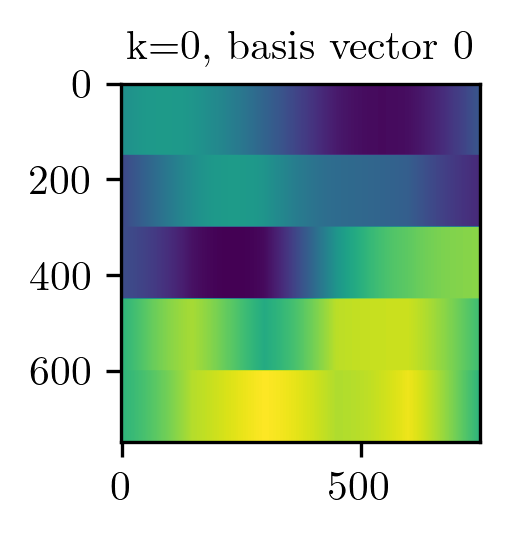

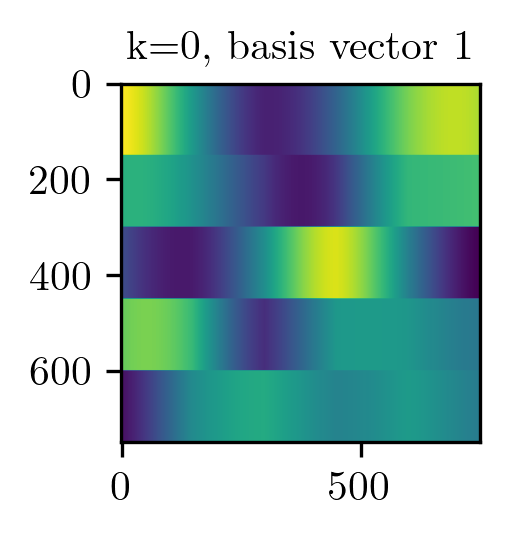

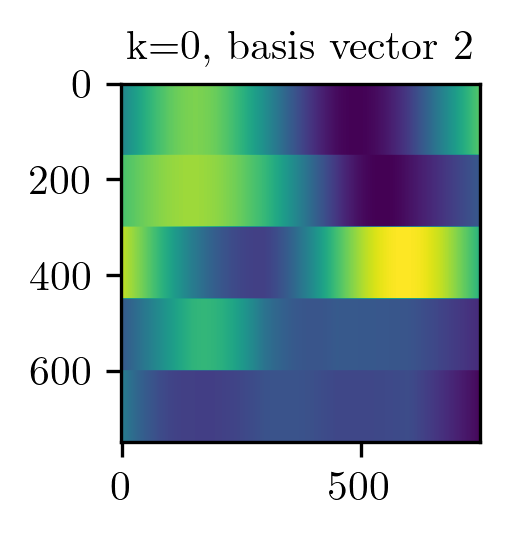

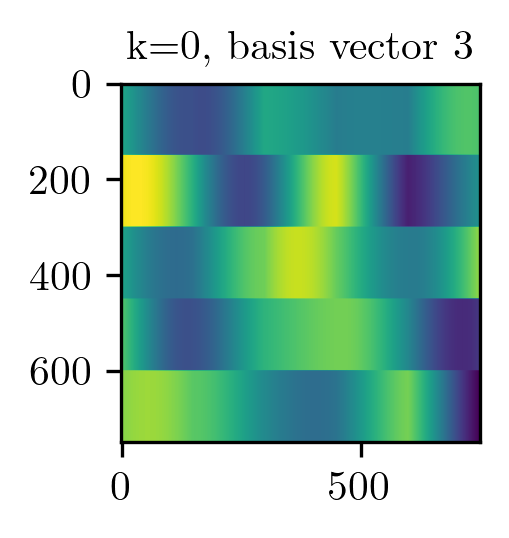

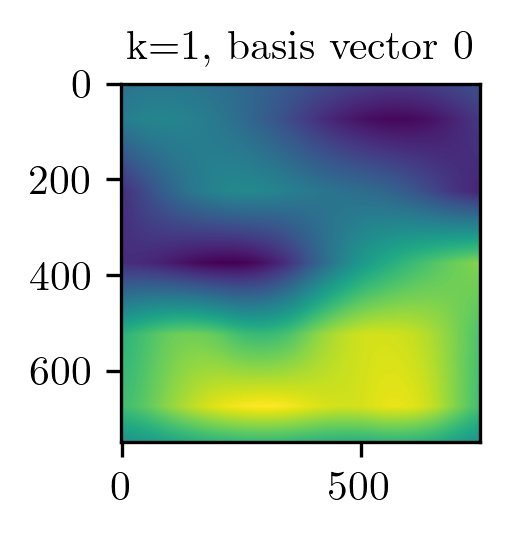

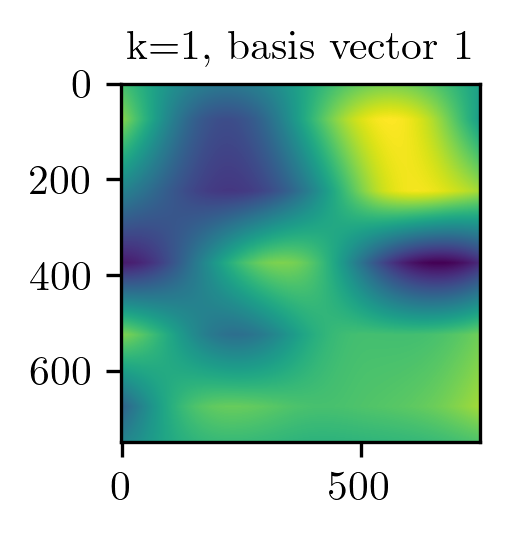

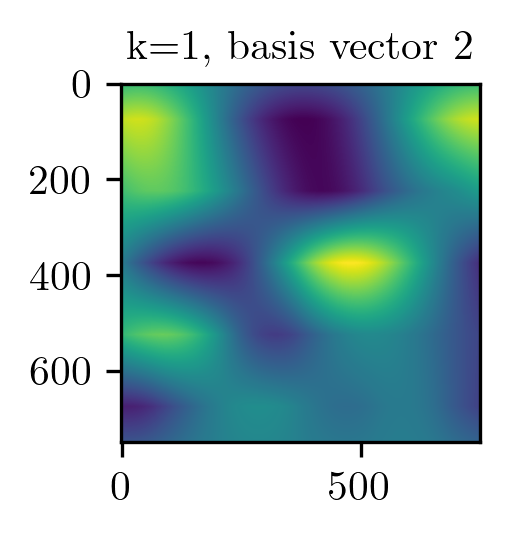

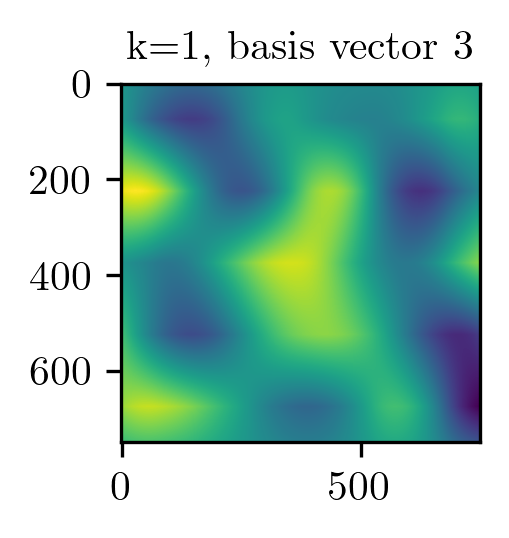

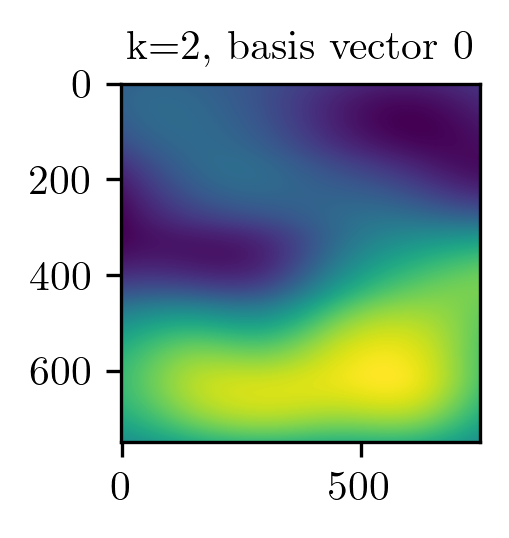

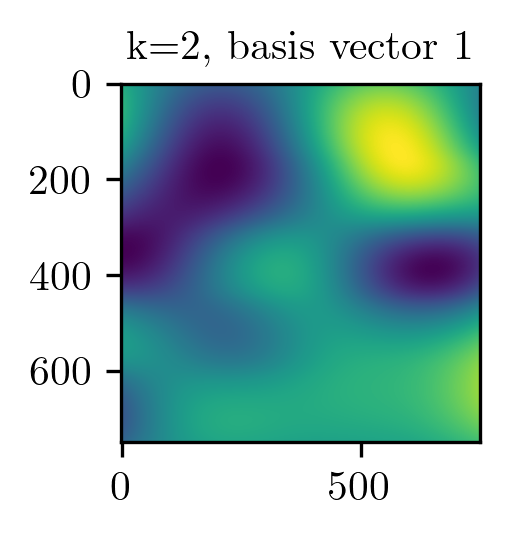

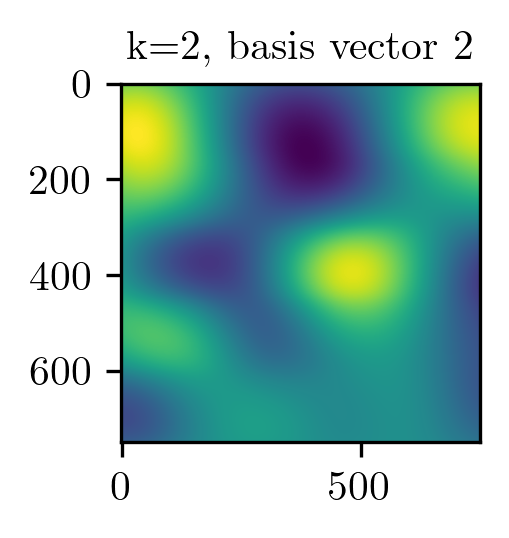

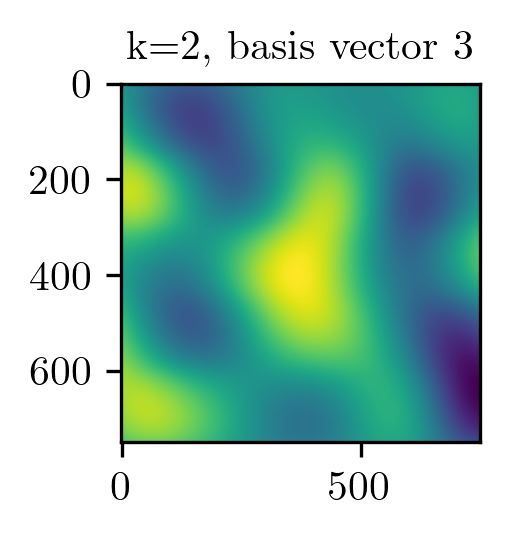

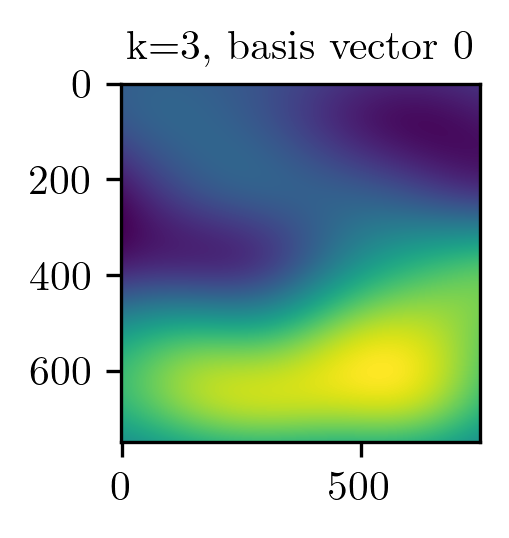

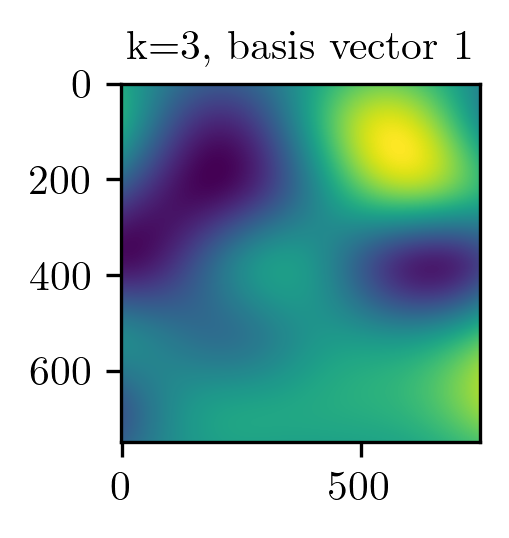

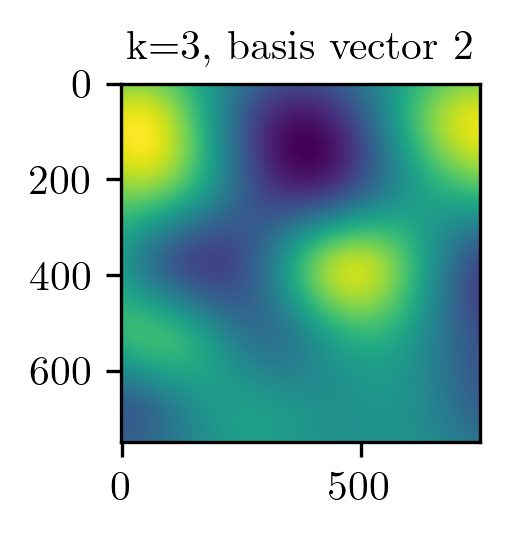

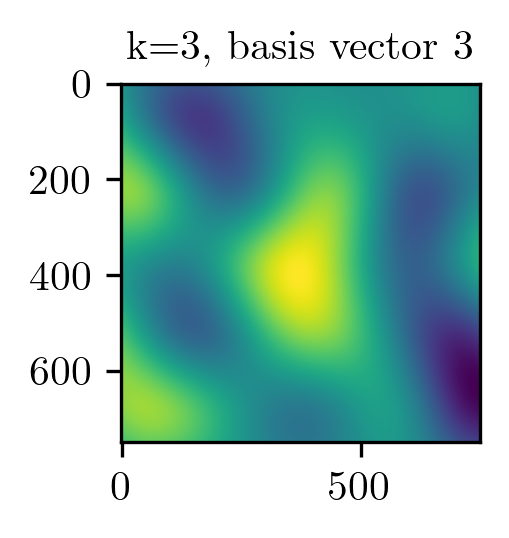

In [12]:
for k in range(4):
    svd_basis = all_SVDs[k]
    for i in range(4):
        plt.figure()
        plt.imshow(svd_basis.U[:, i].reshape(m1, m2))
        plt.title("k="+str(k)+", basis vector "+str(i))
        plt.show()

## check the first 4 basis vectors of row 200

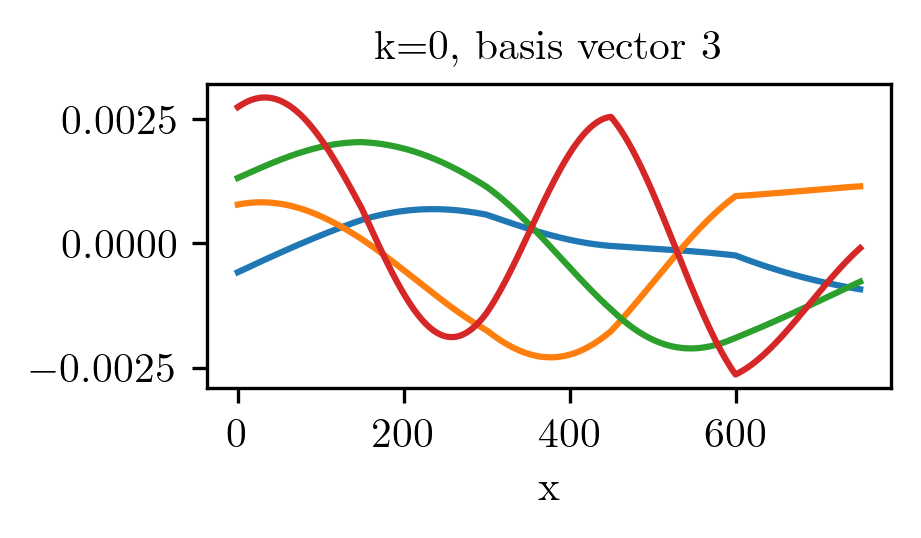

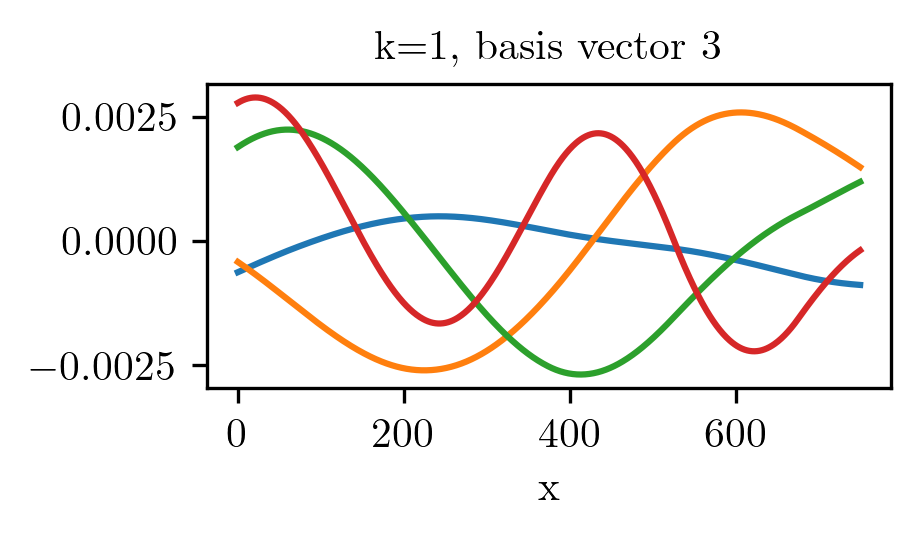

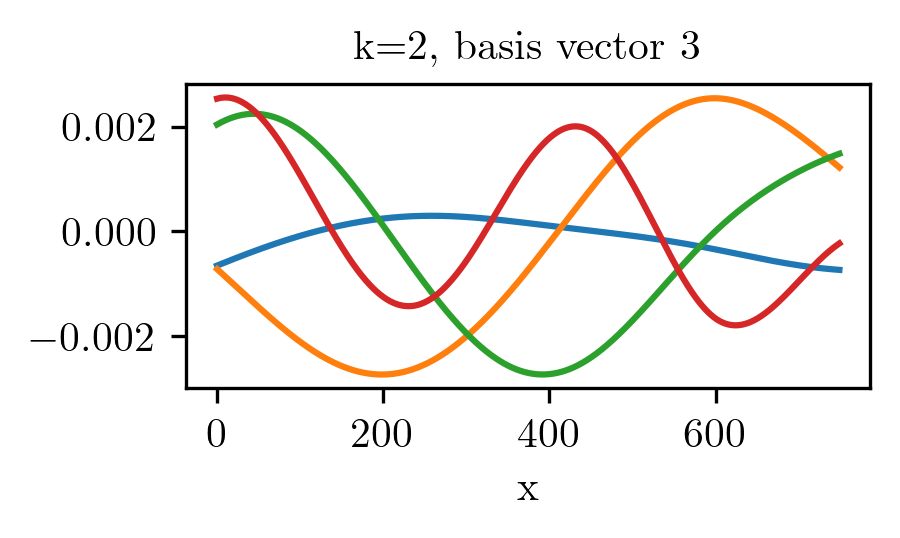

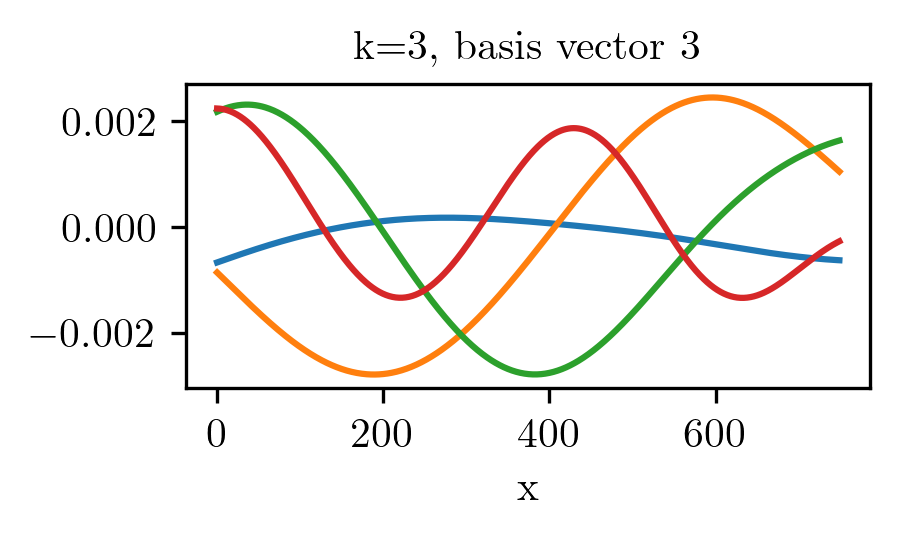

In [13]:
for k in range(4):
    svd_basis = all_SVDs[k]
    plt.figure()
    for i in range(4):
        plt.plot(svd_basis.U[:, i].reshape(m1, m2)[200, :])
        plt.title("k="+str(k)+", basis vector "+str(i))
    plt.xlabel("x")
    plt.show()